<h1>Research Question</h1>
Can we reliably predict a county's electric vehicle (EV) registrations based of of vehicles' model year, manufacturer brand, electric range, and other factors in Washington State?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

import statsmodels.api as sm  # Optional for detailed statistical analysis


## Data Description
We are using a dataset that shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department of Licensing (DOL). It provides key information about vehicle registrations, tax exemptions, and eligibility criteria for clean alternative fuel vehicles, and is updated regularly, with the monthly vehicle count subject to changes due to county assignment processes during registration. A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source. A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source.

The dataset consists of several columns representing various attributes related to each electric vehicle, including: VIN: Vehicle Identification Number; County: The county where the vehicle is registered; City: The city where the vehicle is registered; State: The state (WA for Washington); Postal Code: The postal code of the registration; Model Year: The year the vehicle model was manufactured; Make: The manufacturer brand of the vehicle; Model: The model of the vehicle. Each row in the dataset describes a specific electric vehicle that is registered in Washington State.

## Data Cleaning

In [2]:
df = pd.read_csv('Combined_Data.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(77114, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,income_2023,population_2023
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,6794340.0
1,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,6794340.0
2,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),119926.0,6794340.0
3,3FA6P0SU8H,Thurston,Yelm,WA,98597.0,2017,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0,2.0,122057736,PUGET SOUND ENERGY INC,91522.0,766220.0
4,1N4AZ0CP2D,Yakima,Yakima,WA,98903.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,14.0,150126840,PACIFICORP,65167.0,694445.0


In [3]:
aggregated_df = duckdb.sql("""
    SELECT County, COUNT(*) As "EV Count",
    AVG("Electric Range") AS "Average Electric Range",
    AVG("Model Year") AS "Average Model Year",
    MODE("Make") AS "Popular Brand",
    MODE("Model") AS "Popular Model",
    MODE("Electric Vehicle Type") AS "Popular EV Type",
    AVG("income_2023") AS "Average Income",
    AVG("population_2023") AS "Population",
    FROM df
    GROUP BY County
    ORDER BY County ASC
""").df()
aggregated_df.head()

,County,EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,Average Income,Population
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),64498.0,54015.0
1,Alameda,2,131.000000,2020.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),NaN,NaN
2,Albemarle,2,211.500000,2016.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),NaN,NaN
3,Alexandria,2,326.000000,2020.000000,TESLA,MODEL S,Battery Electric Vehicle (BEV),NaN,NaN
4,Allen,2,121.500000,2017.500000,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),NaN,NaN


## Pre Registration Statements
### Statement 1
**Hypothesis:** Counties with a higher density of BEVs (Battery Electric Vehicles) relative to other types of EVs have higher total EV registrations.

**Analysis:** We will calculate the proportion of BEVs among all EVs for each county. Then, we will perform a linear regression with the BEV proportion (for each county) as the input variable and the total EV registrations (for each county) as the output. The goal is to test whether the coefficient for BEV proportion indicates a meaningful link between BEV density and overall EV registrations within each county. We chose linear regression because it can detect direct correlations between BEV popularity and overall adoption trends. We will test whether BEV > 0. If it is significantly positive, then it indicates that the counties with higher BEV proportion tend to have more total EV registrations. Additionally, if a relationship exists, it could inform further investigation into socioeconomic or geographic factors that may affect EV adoption rates.

In [24]:
ev_density_by_county = duckdb.sql("""
    SELECT 
        County,
        COUNT(*) AS "Total EV Count",  -- Total count of all EVs in the county
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) AS "BEV Count",  -- Count of BEVs
        SUM(CASE WHEN "Electric Vehicle Type" = 'Plug-in Hybrid Electric Vehicle (PHEV)' THEN 1 ELSE 0 END) AS "PHEV Count",  -- Count of PHEVs
        AVG("income_2023") AS "Average Income",  -- Average income in the county
        AVG("population_2023") AS "Average Population",  -- Average population in the county
        -- Calculating BEV proportion directly within the query
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS "BEV Proportion"  -- Proportion of BEVs
    FROM df
    GROUP BY County
    ORDER BY County ASC
""").df()

ev_density_by_county.head()

,County,Total EV Count,BEV Count,PHEV Count,Average Income,Average Population,BEV Proportion
0,Adams,19,10.0,9.0,64498.0,54015.0,0.526316
1,Alameda,2,1.0,1.0,NaN,NaN,0.500000
2,Albemarle,2,2.0,0.0,NaN,NaN,1.000000
3,Alexandria,2,2.0,0.0,NaN,NaN,1.000000
4,Allen,2,1.0,1.0,NaN,NaN,0.500000


In [25]:
# Remove rows where BEV Proportion or Total EV Count is zero or null (to avoid issues in regression)
ev_density_by_county = ev_density_by_county.dropna(subset=["BEV Proportion", "Total EV Count"])
ev_density_by_county = ev_density_by_county[ev_density_by_county["Total EV Count"] > 0]

# Define independent variable (BEV Proportion) and dependent variable (Total EV Count)
X = ev_density_by_county["BEV Proportion"]
y = ev_density_by_county["Total EV Count"]

# Add a constant to the independent variable for the intercept term in the regression model
X = sm.add_constant(X)

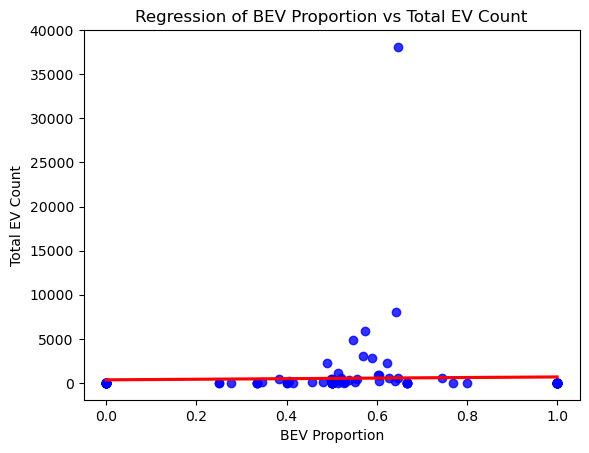

In [27]:
sns.regplot(x="BEV Proportion", y="Total EV Count", data=ev_density_by_county, 
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, 
            ci=None)  
plt.xlabel("BEV Proportion")
plt.ylabel("Total EV Count")
plt.title("Regression of BEV Proportion vs Total EV Count")

plt.show()

In [26]:
# Perform the linear regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2311
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.631
Time:                        18:55:39   Log-Likelihood:                -1407.0
No. Observations:                 148   AIC:                             2818.
Df Residuals:                     146   BIC:                             2824.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            351.3509    443.989      0.

## Pre Registration Statements
### Statement 2
**Hypothesis:** Counties with higher median incomes are correlated with a greater number of registered electric vehicles.

**Analysis:** We will combine EV registration by county and the median income by county from the median income dataset. Where each row represents a different county, we run a linear regression for median income in 2023 as input and the number of registered electric vehicles as output. Because the coefficient can contain signs to indicate a positive or negative relationship between the two variables, we will test whether income  0. If it is significantly positive, then it indicates that high-income countries tend to have more EVs. We will also evaluate the R-squared value to understand how much of the variation in EV registrations is explained by median income and other factors included in the model.

In [9]:
# Filter for non-null data
filtered_df = aggregated_df.dropna(subset=["Average Income", "Population"]).copy()
filtered_df["EVs per 1000"] = (filtered_df["EV Count"] / filtered_df["Population"]) * 1000
filtered_df.head()

,County,EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,Average Income,Population,BEV Count,BEV Proportion,EVs per 1000
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),64498.0,54015.0,19.0,1.0,0.351754
7,Asotin,41,89.414634,2018.975610,TOYOTA,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),67820.0,53745.0,0.0,0.0,0.762862
10,Benton,1120,125.328571,2018.716964,TESLA,MODEL 3,Battery Electric Vehicle (BEV),87992.0,608885.0,1120.0,1.0,1.839428
21,Chelan,510,142.231373,2018.533333,TESLA,LEAF,Battery Electric Vehicle (BEV),84430.0,210625.0,510.0,1.0,2.421365
23,Clallam,573,110.722513,2018.186736,CHEVROLET,LEAF,Battery Electric Vehicle (BEV),68924.0,188135.0,573.0,1.0,3.045685


In [10]:
# Linear regression
X = filtered_df["Average Income"].values.reshape(-1,1)
y = filtered_df["EV Count"].values

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print(f"Coefficient for Median Income: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

R-squared: 0.45
Coefficient for Median Income: 0.30
Intercept: -20691.03


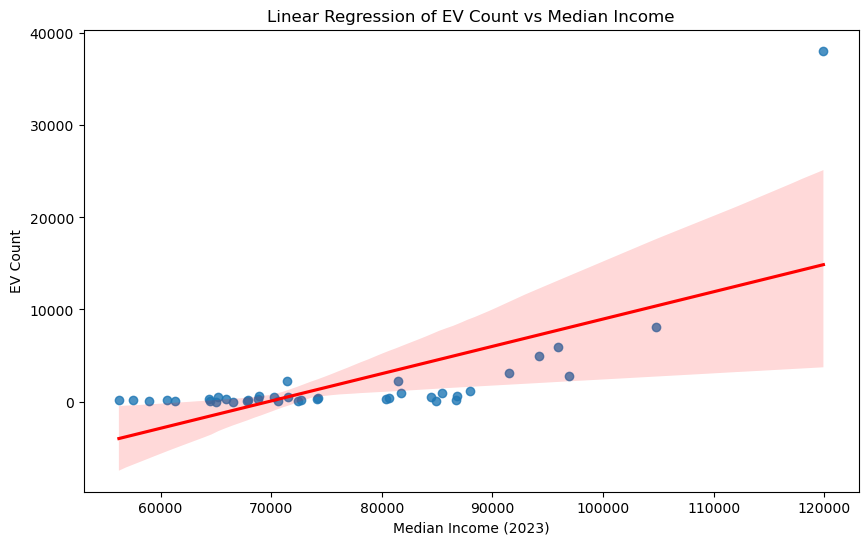

In [11]:
# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_df["Average Income"], y=filtered_df["EV Count"], line_kws={"color": "red"})
plt.title("Linear Regression of EV Count vs Median Income")
plt.xlabel("Average Income (2023)")
plt.ylabel("EV Count")
plt.show()

In [12]:
X_with_const = sm.add_constant(X)  
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     29.94
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           3.26e-06
Time:                        18:41:09   Log-Likelihood:                -383.80
No. Observations:                  39   AIC:                             771.6
Df Residuals:                      37   BIC:                             774.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.069e+04   4208.483     -4.917      0.0

## Multivariate Regression

based on feedback from TA

In [31]:
# Multivariate with model year and electric range
merged_query = """
    SELECT 
        ev_density_by_county.County,
        ev_density_by_county."Total EV Count",
        ev_density_by_county."BEV Count",
        ev_density_by_county."BEV Proportion",
        AVG(df."Model Year") AS "Average Model Year",
        AVG(df."Electric Range") AS "Average Electric Range"
    FROM ev_density_by_county
    JOIN df ON ev_density_by_county.County = df.County
    GROUP BY ev_density_by_county.County, ev_density_by_county."Total EV Count", ev_density_by_county."BEV Count", ev_density_by_county."BEV Proportion"
"""

merged_df = duckdb.sql(merged_query).df()

print(merged_df.head())

       County  Total EV Count  BEV Count  BEV Proportion  Average Model Year  \
0     Spokane            2277     1117.0        0.490558          2018.87791   
1    Skamania             100       53.0        0.530000          2018.95000   
2       Marin               1        0.0        0.000000          2022.00000   
3  Montgomery               5        2.0        0.400000          2020.40000   
4      Platte               1        1.0        1.000000          2020.00000   

   Average Electric Range  
0               112.29249  
1               128.17000  
2                26.00000  
3               103.40000  
4               291.00000  


In [32]:
merged_df_clean = merged_df.dropna()

# Define the predictors (independent variables)
X = merged_df_clean[["BEV Proportion", "Average Model Year", "Average Electric Range"]]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Define the target (dependent variable)
y = merged_df_clean["Total EV Count"]

Fit the multivariate regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3035
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.823
Time:                        19:03:02   Log-Likelihood:                -1397.6
No. Observations:                 147   AIC:                             2803.
Df Residuals:                     143   BIC:                             2815.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.01

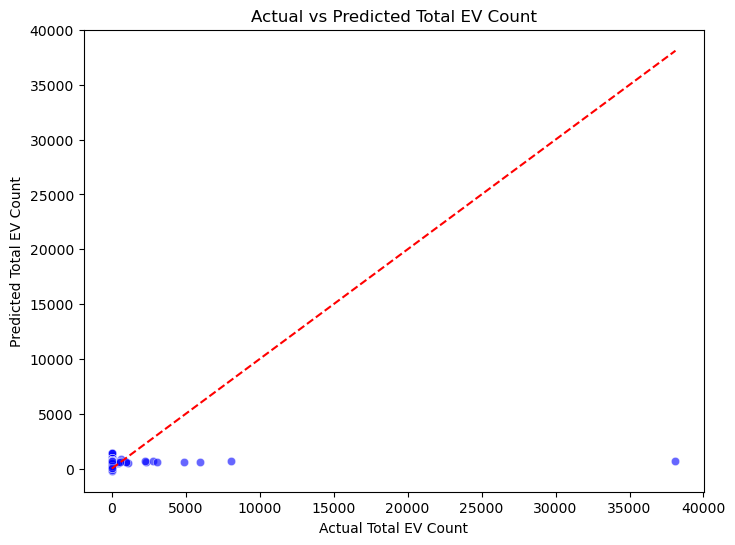

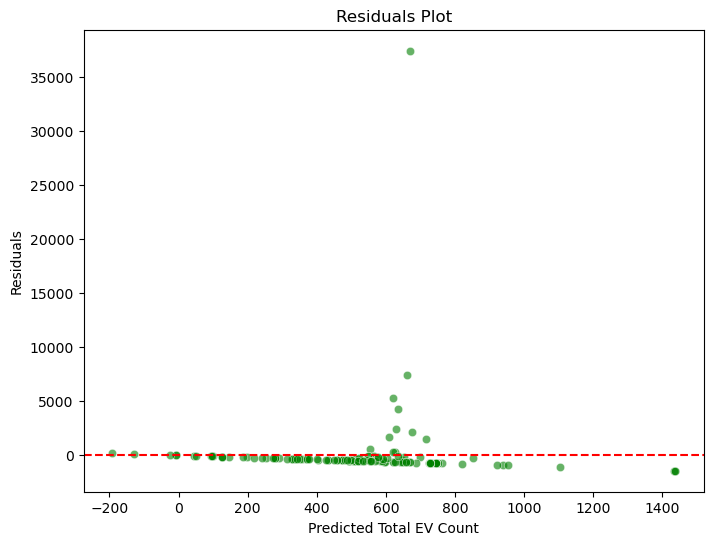

In [33]:
Generate the predictions (fitted values)
merged_df_clean['Predicted EV Count'] = model.predict(X)

# Plot the actual vs predicted EV count
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df_clean['Total EV Count'], y=merged_df_clean['Predicted EV Count'], color='blue', alpha=0.6)
plt.plot([merged_df_clean['Total EV Count'].min(), merged_df_clean['Total EV Count'].max()],
         [merged_df_clean['Total EV Count'].min(), merged_df_clean['Total EV Count'].max()],
         color='red', linestyle='--')  # Line of perfect prediction
plt.title('Actual vs Predicted Total EV Count')
plt.xlabel('Actual Total EV Count')
plt.ylabel('Predicted Total EV Count')
plt.show()

# Residuals Plot
merged_df_clean['Residuals'] = merged_df_clean['Total EV Count'] - merged_df_clean['Predicted EV Count']
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df_clean['Predicted EV Count'], y=merged_df_clean['Residuals'], color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Total EV Count')
plt.ylabel('Residuals')
plt.show()